In [ ]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
!pip install torchsummaryX
from torchsummaryX import summary
from sklearn.model_selection import train_test_split
drive.mount('/gdrive/')

Mounted at /gdrive/


# Create Dataset

1. Import Flickr-Faces-HQ Dataset (FFHQ) of faces. We imported this dataset into our goolge drives directly and extracted about 4000 images from the original dataset. Source: https://github.com/NVlabs/ffhq-dataset.

2. Create the mask dataset using MaskTheFace. This dataset was created using the source code from the MaskTheFace github: https://github.com/aqeelanwar/MaskTheFace. The authors of MaskTheFace are Aqeel Anwar and Arijit Raychowdhury. Disclaimer: we do not take credit for the MaskTheFace source code, we are only using it to create our dataset.

**PLEASE SKIP THIS STEP IF THE DATASET HAS ALREADY BEEN CREATED**

In [ ]:
!git clone https://github.com/aqeelanwar/MaskTheFace.git

Cloning into 'MaskTheFace'...
remote: Enumerating objects: 3125, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3125 (delta 0), reused 0 (delta 0), pack-reused 3122
Receiving objects: 100% (3125/3125), 235.03 MiB | 30.64 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [ ]:
!pip install -r MaskTheFace/requirements.txt

     |████████████████████████████████| 163kB 17.7MB/s 
     |████████████████████████████████| 3.2MB 36.6MB/s 
     |████████████████████████████████| 100.2MB 114kB/s 
     |████████████████████████████████| 20.2MB 1.4MB/s 
     |████████████████████████████████| 28.2MB 80kB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for dlib: filename=dlib-19.19.0-cp37-cp37m-linux_x86_64.whl size=3888213 sha256=2be0bc7928895115e9a493aad403cdf851cf05b6c22d459004af215c04fa2488
  Stored in directory: /root/.cache/pip/wheels/96/ac/11/8aadec62cb4fb5b264a9b1b042caf415de9a75f5e165d79a51
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=3b2b17a05e510b995e6eca059525b8c521518a12c685978df8f9118ef25f8274
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
  Created wheel for imutils: filename=imuti

In [ ]:
import subprocess as sbp
import os

path= '/gdrive/MyDrive/ffhq-dataset/thumbnails128x128/66000'
fol = os.listdir(path)
p2 = '/gdrive/MyDrive/facemask_type_dataset'

for i in fol:
    p1 = os.path.join(path,i)
    p3 = 'cp -r ' + p1 +' ' + p2+'/.'
    sbp.Popen(p3,shell=True)

In [ ]:
path= '/gdrive/MyDrive/ffhq-dataset/thumbnails128x128/67000'
fol = os.listdir(path)
p2 = '/gdrive/MyDrive/facemask_type_dataset'

for i in fol:
    p1 = os.path.join(path,i)
    p3 = 'cp -r ' + p1 +' ' + p2+'/.'
    sbp.Popen(p3,shell=True)

In [ ]:
path= '/gdrive/MyDrive/ffhq-dataset/thumbnails128x128/68000'
fol = os.listdir(path)
p2 = '/gdrive/MyDrive/facemask_type_dataset'

for i in fol:
    p1 = os.path.join(path,i)
    p3 = 'cp -r ' + p1 +' ' + p2+'/.'
    sbp.Popen(p3,shell=True)

In [ ]:
path= '/gdrive/MyDrive/ffhq-dataset/thumbnails128x128/69000'
fol = os.listdir(path)
p2 = '/gdrive/MyDrive/facemask_type_dataset'

for i in fol:
    p1 = os.path.join(path,i)
    p3 = 'cp -r ' + p1 +' ' + p2+'/.'
    sbp.Popen(p3,shell=True)

In [ ]:
import os, os.path
# checking number of images in directory
DIR = '/gdrive/MyDrive/facemask_type_dataset'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

4000


In [ ]:
%cd /MaskTheFace
!python mask_the_face.py --path '/gdrive/MyDrive/facemask_type_dataset' --code cloth,N95,KN95,surgical,gas

[Errno 2] No such file or directory: '/MaskTheFace'
/content/MaskTheFace
 __  __           _ _______ _          ______
|  \/  |         | |__   __| |        |  ____|
| \  / | __ _ ___| | _| |  | |__   ___| |__ __ _  ___ ___
| |\/| |/ _` / __| |/ / |  | '_ \ / _ \  __/ _` |/ __/ _ \
| |  | | (_| \__ \   <| |  | | | |  __/ | | (_| | (_|  __/
|_|  |_|\__,_|___/_|\_\_|  |_| |_|\___|_|  \__,_|\___\___|
-------------------------------------------------------------
-------------------- Masking image files --------------------
-------------------------------------------------------------
100% 4000/4000 [04:01<00:00, 16.57it/s]
-------------------------------------------------------------
----------------- Masking image directories -----------------
-------------------------------------------------------------
0it [00:00, ?it/s]
Processing Done


# Data Preprocessing

Preprocess the MaskTheFace dataset so that it can be inputted into the CNN model

In [ ]:
import os

DIR = '/gdrive/MyDrive/facemask_type_dataset_masked'

N95 = '_N95'
KN95 = 'KN95'
surgical = 'surgical'
gas = 'gas'
cloth = 'cloth'

count_N95 = 0
count_surgical = 0
count_KN95 = 0
count_cloth = 0
count_gas = 0
count_extra = 0

col = ['filename', 'mask_type', 'class']
data_df = pd.DataFrame(columns=col)
print(data_df)

for file in os.listdir(DIR):
  if (N95 in file):
    count_N95+=1
    data_df = data_df.append({'filename':file, 'mask_type':N95, 'class':0}, ignore_index=True)
  elif (surgical in file):
    count_surgical+=1
    data_df = data_df.append({'filename':file, 'mask_type':surgical, 'class':1}, ignore_index=True)
  elif (KN95 in file):
    count_KN95+=1
    data_df = data_df.append({'filename':file, 'mask_type':KN95, 'class':2}, ignore_index=True)
  elif (gas in file):
    count_gas+=1
    data_df = data_df.append({'filename':file, 'mask_type':gas, 'class':3}, ignore_index=True)
  elif (cloth in file):
    count_cloth+=1
    data_df = data_df.append({'filename':file, 'mask_type':cloth, 'class':4}, ignore_index=True)

print('N95 masks:', count_N95)
print('KN95 masks:', count_KN95)
print('surgical masks:', count_surgical)
print('gas masks:', count_gas)
print('cloth masks:', count_cloth)

total = count_N95 + count_KN95 + count_surgical + count_gas + count_cloth
print(total)
data_df.head()

Empty DataFrame
Columns: [filename, mask_type, class]
Index: []
N95 masks: 965
KN95 masks: 913
surgical masks: 931
gas masks: 969
cloth masks: 938
4716


,filename,mask_type,class
0,68993_KN95.png,KN95,2
1,69004_cloth.png,cloth,4
2,68997_cloth.png,cloth,4
3,68995_N95.png,_N95,0
4,69006_surgical.png,surgical,1


In [ ]:
# Split the file into training, validation, and testing

X = data_df.drop('class', axis=1)
y = data_df['class']
X_train, X_validtest, y_train, y_validtest = train_test_split(X,y, test_size=0.3, random_state=4211)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=4211)

X_train['class'] = y_train
X_valid['class'] = y_valid
X_test['class'] = y_test

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train.to_csv('/content/train.csv')
X_valid.to_csv('/content/valid.csv')
X_test.to_csv('/content/test.csv')
print(len(X_train), len(X_valid), len(X_test))

3301 707 708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
# Make the dataset class
class FacemaskTypeDataset(Dataset):
  def __init__(self, csv_file, transform=None, rgb=False):
    self.index_df = pd.read_csv(csv_file)
    self.transform = transform
    self.DIR = '/gdrive/MyDrive/facemask_type_dataset_masked'
    if rgb:
      self.is_rgb = True
    else:
      self.is_rgb = False

  def __getitem__(self, idx):
    img = os.path.join(self.DIR,self.index_df.loc[idx, 'filename'])
    image = Image.open(img)
    if self.is_rgb:
      image = image.convert('RGB')
    image_tr = self.transform(image)
    label = self.index_df.loc[idx, 'class']
    return image_tr, label

  def __len__(self):
    return len(self.index_df)

In [ ]:
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train = FacemaskTypeDataset(train_path, transform=transform0)
dataset_valid = FacemaskTypeDataset(valid_path, transform=transform0)
dataset_test = FacemaskTypeDataset(test_path, transform=transform0)

# Make iterators
bs = 128

train_loader = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

#dataiter = iter(train_loader)
#image, label = next(dataiter)

# Baseline Model

Create and train the baseline PA2Net Model

In [ ]:
class PA2Net(nn.Module):
    def __init__(self, first_in_channel=1):
        super(PA2Net, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=first_in_channel, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.norm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.norm6 = nn.BatchNorm2d(512)
        self.pool2 = nn.AvgPool2d(16, 16, padding=0)

        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

        self.fully_connected = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,5)
        )
    
    
    def forward(self, x):
        # Convolution layers for the images
        x = F.relu(self.norm1(self.conv1(x))) #32, 32, 32 
        x = F.relu(self.norm2(self.conv2(x))) #32, 32, 32
        x = self.pool1(x) #32, 16, 16
        x = F.relu(self.norm3(self.conv3(x))) #64, 16, 16
        x = F.relu(self.norm4(self.conv4(x))) #128, 16, 16
        x = F.relu(self.norm5(self.conv5(x))) #256, 16, 16
        x = F.relu(self.norm6(self.conv6(x))) #512, 16, 16
        x = self.pool2(x) #512, 1, 1
        x = x.view(-1, 512)
  
        # Full connected layers and ouptut
        x = self.fully_connected(x)
        return x


In [ ]:
model = PA2Net()
summary(model, torch.zeros((1, 1, 32, 32)))

                                  Kernel Shape      Output Shape    Params  \
Layer                                                                        
0_conv1                          [1, 32, 3, 3]   [1, 32, 32, 32]     320.0   
1_norm1                                   [32]   [1, 32, 32, 32]      64.0   
2_conv2                         [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k   
3_norm2                                   [32]   [1, 32, 32, 32]      64.0   
4_pool1                                      -   [1, 32, 16, 16]         -   
5_conv3                         [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k   
6_norm3                                   [64]   [1, 64, 16, 16]     128.0   
7_conv4                        [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
8_norm4                                  [128]  [1, 128, 16, 16]     256.0   
9_conv5                       [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   
10_norm5                                 [256]  [1, 256, 16, 16]

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[1, 32, 3, 3]","[1, 32, 32, 32]",320.0,294912.0
1_norm1,[32],"[1, 32, 32, 32]",64.0,32.0
2_conv2,"[32, 32, 3, 3]","[1, 32, 32, 32]",9248.0,9437184.0
3_norm2,[32],"[1, 32, 32, 32]",64.0,32.0
4_pool1,-,"[1, 32, 16, 16]",NaN,NaN
5_conv3,"[32, 64, 3, 3]","[1, 64, 16, 16]",18496.0,4718592.0
6_norm3,[64],"[1, 64, 16, 16]",128.0,64.0
7_conv4,"[64, 128, 3, 3]","[1, 128, 16, 16]",73856.0,18874368.0
8_norm4,[128],"[1, 128, 16, 16]",256.0,128.0


In [ ]:
"""
These helper functions are used to train the model and calculate performance metrics
"""

def save_model(save_path, model):
    torch.save(model, save_path)
    print(f'Model saved to {save_path}')

def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, device, save_name):
    
    train_loss_ls = []
    val_loss_ls = []
    steps_ls = []
    step_count = 0
    best_model = None
    
    best_val_loss = float("Inf")
    best_macro_avg = 0
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_running_corrects = 0
        train_size = 0
        train_loss_count = 0
        for input_x, target in tqdm(train_loader):
            net.train()
            input_x = input_x.to(device)
            target = target.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = net(input_x)
            loss = criterion(outputs, target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step_count += 1
            train_loss_count += 1

            preds = []
            for o in outputs:
                preds.append(torch.argmax(o))
            preds = torch.tensor(preds).to(device)
            train_running_loss += loss.item()
            train_running_corrects += torch.sum(preds == target.data)
            train_size += len(target)   
        
        # Calcualte train loss/acc
        train_loss = train_running_loss / train_loss_count
        train_acc = train_running_corrects / (train_size)
        
        # Every epoch, calculate val loss
        with torch.no_grad():
            net.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            pred_ls = []
            target_ls = []
            tmp_ls = []
            # Predict on validation dataset
            for input_x, target in valid_loader:

                input_x = input_x.to(device)
                target = target.to(device)

                outputs = net(input_x)
                loss = criterion(outputs, target)

                val_running_loss += loss.item()
                preds = torch.argmax(outputs)
                val_running_corrects += torch.sum(preds == target.data)
                pred_ls.append(preds.item())
                target_ls.append(target.item())
            
            cr = classification_report(target_ls, pred_ls)
            cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
            macro_avg = cr_dict['macro avg']['f1-score']
            valid_loss = val_running_loss / len(valid_loader)
            valid_acc = val_running_corrects / float(len(valid_loader.dataset))
            

        # Save best macro average
        if macro_avg > best_macro_avg:
            best_macro_avg = macro_avg
            best_val_loss = valid_loss
            best_model = net
            save_model(save_name, net)

        # Store loss and accuracy in list for plotting
        train_loss_ls.append(train_loss)
        val_loss_ls.append(valid_loss)
        steps_ls.append(step_count)

        # print and continue
        print('Epoch [{}/{}], Step {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Macro Avg: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, step_count, train_loss, train_acc, macro_avg, valid_loss, valid_acc))
        print(cr)
        
    print('Finished Training')
    print('Best validation macro average:', best_macro_avg)
    print('Best validation loss:', best_val_loss)
    return train_loss_ls, val_loss_ls, steps_ls, best_model

In [ ]:
# Baseline Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2net_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_best.pt
Epoch [1/40], Step 26, Train Loss: 0.9571, Train Acc: 0.5977, Val Macro Avg: 0.1918, Valid Loss: 1.8379,  Valid Acc: 0.2687
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       149
           1       0.26      0.95      0.41       144
           2       0.18      0.11      0.13       141
           3       0.00      0.00      0.00       136
           4       0.80      0.27      0.40       137

    accuracy                           0.27       707
   macro avg       0.25      0.27      0.19       707
weighted avg       0.25      0.27      0.19       707



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to pa2net_best.pt
Epoch [2/40], Step 52, Train Loss: 0.2980, Train Acc: 0.8925, Val Macro Avg: 0.6888, Valid Loss: 0.7849,  Valid Acc: 0.7185
              precision    recall  f1-score   support

           0       0.55      0.91      0.68       149
           1       0.95      0.53      0.68       144
           2       0.83      0.21      0.34       141
           3       0.92      0.96      0.94       136
           4       0.67      1.00      0.81       137

    accuracy                           0.72       707
   macro avg       0.79      0.72      0.69       707
weighted avg       0.78      0.72      0.69       707




Model saved to pa2net_best.pt
Epoch [3/40], Step 78, Train Loss: 0.1367, Train Acc: 0.9549, Val Macro Avg: 0.9319, Valid Loss: 0.2093,  Valid Acc: 0.9321
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       149
           1       0.99      0.84      0.91       144
           2       0.85      0.95      0.90       141
           3       0.99      0.90      0.94       136
           4       0.89      1.00      0.94       137

    accuracy                           0.93       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [4/40], Step 104, Train Loss: 0.1316, Train Acc: 0.9579, Val Macro Avg: 0.7254, Valid Loss: 0.7545,  Valid Acc: 0.7652
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       149
           1       1.00      0.14      0.24       144
           2       0.53      0.94      0.68       141
           3       0.81      0.99      0.89       136
           4       1.00      0.77      0.87       137

    accuracy                           0.77       707
   macro avg       0.85      0.77      0.73       707
weighted avg       0.85      0.77      0.72       707




Epoch [5/40], Step 130, Train Loss: 0.0510, Train Acc: 0.9849, Val Macro Avg: 0.7892, Valid Loss: 0.8297,  Valid Acc: 0.7893
              precision    recall  f1-score   support

           0       0.99      0.46      0.62       149
           1       0.65      1.00      0.79       144
           2       0.58      0.69      0.63       141
           3       1.00      0.87      0.93       136
           4       0.99      0.96      0.97       137

    accuracy                           0.79       707
   macro avg       0.84      0.79      0.79       707
weighted avg       0.84      0.79      0.79       707




Epoch [6/40], Step 156, Train Loss: 0.0618, Train Acc: 0.9815, Val Macro Avg: 0.8841, Valid Loss: 0.4492,  Valid Acc: 0.8798
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       149
           1       0.99      0.64      0.78       144
           2       0.63      0.99      0.77       141
           3       1.00      0.99      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           0.88       707
   macro avg       0.92      0.88      0.88       707
weighted avg       0.92      0.88      0.88       707




Model saved to pa2net_best.pt
Epoch [7/40], Step 182, Train Loss: 0.0315, Train Acc: 0.9903, Val Macro Avg: 0.9479, Valid Loss: 0.1879,  Valid Acc: 0.9477
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       149
           1       0.97      0.99      0.98       144
           2       0.97      0.98      0.97       141
           3       0.83      1.00      0.91       136
           4       1.00      0.96      0.98       137

    accuracy                           0.95       707
   macro avg       0.95      0.95      0.95       707
weighted avg       0.95      0.95      0.95       707




Epoch [8/40], Step 208, Train Loss: 0.0198, Train Acc: 0.9945, Val Macro Avg: 0.9461, Valid Loss: 0.1544,  Valid Acc: 0.9463
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       149
           1       1.00      0.84      0.91       144
           2       0.91      0.94      0.92       141
           3       0.99      0.99      0.99       136
           4       0.90      1.00      0.95       137

    accuracy                           0.95       707
   macro avg       0.95      0.95      0.95       707
weighted avg       0.95      0.95      0.95       707




Model saved to pa2net_best.pt
Epoch [9/40], Step 234, Train Loss: 0.0166, Train Acc: 0.9952, Val Macro Avg: 0.9791, Valid Loss: 0.0653,  Valid Acc: 0.9788
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       149
           1       0.96      1.00      0.98       144
           2       0.95      0.98      0.96       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [10/40], Step 260, Train Loss: 0.0263, Train Acc: 0.9924, Val Macro Avg: 0.9764, Valid Loss: 0.0852,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       149
           1       0.92      0.99      0.95       144
           2       0.98      0.94      0.96       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_best.pt
Epoch [11/40], Step 286, Train Loss: 0.0101, Train Acc: 0.9985, Val Macro Avg: 0.9873, Valid Loss: 0.0475,  Valid Acc: 0.9873
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       149
           1       1.00      0.97      0.99       144
           2       0.98      0.98      0.98       141
           3       0.99      0.99      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [12/40], Step 312, Train Loss: 0.0091, Train Acc: 0.9979, Val Macro Avg: 0.9847, Valid Loss: 0.0594,  Valid Acc: 0.9844
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       149
           1       0.95      0.99      0.97       144
           2       0.99      0.97      0.98       141
           3       0.99      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.99      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [13/40], Step 338, Train Loss: 0.0070, Train Acc: 0.9979, Val Macro Avg: 0.9692, Valid Loss: 0.1175,  Valid Acc: 0.9689
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.89      0.99      0.94       144
           2       1.00      0.89      0.94       141
           3       0.99      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [14/40], Step 364, Train Loss: 0.0053, Train Acc: 0.9988, Val Macro Avg: 0.9859, Valid Loss: 0.0652,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.99      0.99      0.99       144
           2       1.00      0.98      0.99       141
           3       0.94      1.00      0.97       136
           4       1.00      0.99      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [15/40], Step 390, Train Loss: 0.0029, Train Acc: 0.9997, Val Macro Avg: 0.9649, Valid Loss: 0.1110,  Valid Acc: 0.9646
              precision    recall  f1-score   support

           0       0.99      0.91      0.94       149
           1       0.92      1.00      0.96       144
           2       1.00      0.92      0.96       141
           3       0.93      1.00      0.96       136
           4       1.00      1.00      1.00       137

    accuracy                           0.96       707
   macro avg       0.97      0.97      0.96       707
weighted avg       0.97      0.96      0.96       707




Epoch [16/40], Step 416, Train Loss: 0.0171, Train Acc: 0.9958, Val Macro Avg: 0.9247, Valid Loss: 0.3484,  Valid Acc: 0.9236
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       149
           1       0.92      0.91      0.91       144
           2       0.96      0.78      0.86       141
           3       0.99      0.99      0.99       136
           4       1.00      0.94      0.97       137

    accuracy                           0.92       707
   macro avg       0.93      0.92      0.92       707
weighted avg       0.93      0.92      0.92       707




Epoch [17/40], Step 442, Train Loss: 0.0216, Train Acc: 0.9927, Val Macro Avg: 0.7193, Valid Loss: 1.3437,  Valid Acc: 0.7426
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       149
           1       0.48      0.99      0.64       144
           2       1.00      0.20      0.33       141
           3       0.87      1.00      0.93       136
           4       0.99      1.00      0.99       137

    accuracy                           0.74       707
   macro avg       0.86      0.75      0.72       707
weighted avg       0.86      0.74      0.72       707




Epoch [18/40], Step 468, Train Loss: 0.0091, Train Acc: 0.9973, Val Macro Avg: 0.9693, Valid Loss: 0.1163,  Valid Acc: 0.9689
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       149
           1       0.99      0.89      0.94       144
           2       0.88      0.99      0.93       141
           3       0.99      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [19/40], Step 494, Train Loss: 0.0065, Train Acc: 0.9979, Val Macro Avg: 0.9330, Valid Loss: 0.2386,  Valid Acc: 0.9321
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       149
           1       0.99      0.99      0.99       144
           2       0.99      0.85      0.92       141
           3       0.83      1.00      0.91       136
           4       1.00      0.96      0.98       137

    accuracy                           0.93       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [20/40], Step 520, Train Loss: 0.0126, Train Acc: 0.9961, Val Macro Avg: 0.8077, Valid Loss: 0.7495,  Valid Acc: 0.8303
              precision    recall  f1-score   support

           0       0.60      0.99      0.75       149
           1       0.99      0.88      0.93       144
           2       0.88      0.98      0.93       141
           3       1.00      0.29      0.45       136
           4       0.98      0.99      0.99       137

    accuracy                           0.83       707
   macro avg       0.89      0.83      0.81       707
weighted avg       0.89      0.83      0.81       707




Epoch [21/40], Step 546, Train Loss: 0.0130, Train Acc: 0.9955, Val Macro Avg: 0.9859, Valid Loss: 0.0465,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       149
           1       1.00      0.98      0.99       144
           2       0.99      0.96      0.98       141
           3       1.00      1.00      1.00       136
           4       0.96      1.00      0.98       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [22/40], Step 572, Train Loss: 0.0100, Train Acc: 0.9967, Val Macro Avg: 0.9790, Valid Loss: 0.0660,  Valid Acc: 0.9788
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       149
           1       0.98      0.99      0.99       144
           2       0.97      0.99      0.98       141
           3       1.00      0.94      0.97       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_best.pt
Epoch [23/40], Step 598, Train Loss: 0.0079, Train Acc: 0.9967, Val Macro Avg: 0.9889, Valid Loss: 0.0562,  Valid Acc: 0.9887
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.98      0.99      0.98       144
           2       0.98      0.99      0.98       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [24/40], Step 624, Train Loss: 0.0109, Train Acc: 0.9976, Val Macro Avg: 0.9720, Valid Loss: 0.0937,  Valid Acc: 0.9717
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       149
           1       0.99      0.98      0.98       144
           2       1.00      0.89      0.94       141
           3       0.98      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [25/40], Step 650, Train Loss: 0.0197, Train Acc: 0.9933, Val Macro Avg: 0.9860, Valid Loss: 0.0658,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.98      0.99      0.99       144
           2       1.00      0.94      0.97       141
           3       0.99      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [26/40], Step 676, Train Loss: 0.0310, Train Acc: 0.9891, Val Macro Avg: 0.8435, Valid Loss: 0.7131,  Valid Acc: 0.8487
              precision    recall  f1-score   support

           0       1.00      0.83      0.90       149
           1       0.62      0.99      0.77       144
           2       0.81      0.45      0.58       141
           3       0.99      0.99      0.99       136
           4       0.97      1.00      0.99       137

    accuracy                           0.85       707
   macro avg       0.88      0.85      0.84       707
weighted avg       0.88      0.85      0.84       707




Epoch [27/40], Step 702, Train Loss: 0.0274, Train Acc: 0.9906, Val Macro Avg: 0.9624, Valid Loss: 0.1549,  Valid Acc: 0.9618
              precision    recall  f1-score   support

           0       0.98      0.87      0.93       149
           1       0.95      0.99      0.97       144
           2       0.90      0.98      0.94       141
           3       0.99      0.99      0.99       136
           4       1.00      0.99      0.99       137

    accuracy                           0.96       707
   macro avg       0.96      0.96      0.96       707
weighted avg       0.96      0.96      0.96       707




Epoch [28/40], Step 728, Train Loss: 0.0083, Train Acc: 0.9976, Val Macro Avg: 0.9746, Valid Loss: 0.0857,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       149
           1       0.98      1.00      0.99       144
           2       1.00      0.91      0.95       141
           3       0.96      0.99      0.98       136
           4       0.99      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.97       707
weighted avg       0.98      0.97      0.97       707




Model saved to pa2net_best.pt
Epoch [29/40], Step 754, Train Loss: 0.0034, Train Acc: 0.9991, Val Macro Avg: 0.9958, Valid Loss: 0.0193,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Model saved to pa2net_best.pt
Epoch [30/40], Step 780, Train Loss: 0.0013, Train Acc: 0.9997, Val Macro Avg: 0.9958, Valid Loss: 0.0232,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [31/40], Step 806, Train Loss: 0.0004, Train Acc: 1.0000, Val Macro Avg: 0.9944, Valid Loss: 0.0222,  Valid Acc: 0.9943
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [32/40], Step 832, Train Loss: 0.0003, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0202,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [33/40], Step 858, Train Loss: 0.0003, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0200,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [34/40], Step 884, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0227,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [35/40], Step 910, Train Loss: 0.0005, Train Acc: 0.9997, Val Macro Avg: 0.9902, Valid Loss: 0.0471,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.97      0.98       144
           2       0.97      0.99      0.98       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [36/40], Step 936, Train Loss: 0.0004, Train Acc: 1.0000, Val Macro Avg: 0.9944, Valid Loss: 0.0351,  Valid Acc: 0.9943
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.98      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [37/40], Step 962, Train Loss: 0.0003, Train Acc: 1.0000, Val Macro Avg: 0.9944, Valid Loss: 0.0245,  Valid Acc: 0.9943
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [38/40], Step 988, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0227,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [39/40], Step 1014, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0228,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [40/40], Step 1040, Train Loss: 0.0002, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0233,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707

Finished Training
Best validation macro average: 0.9958492063492063
Best validation loss: 0.023219100486627457


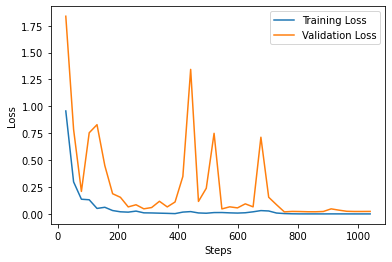

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

# Experiments

1. RGB Model


In [ ]:
# RGB Model
model = PA2Net(first_in_channel=3)
summary(model, torch.zeros((1, 3, 32, 32)))

                                  Kernel Shape      Output Shape    Params  \
Layer                                                                        
0_conv1                          [3, 32, 3, 3]   [1, 32, 32, 32]     896.0   
1_norm1                                   [32]   [1, 32, 32, 32]      64.0   
2_conv2                         [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k   
3_norm2                                   [32]   [1, 32, 32, 32]      64.0   
4_pool1                                      -   [1, 32, 16, 16]         -   
5_conv3                         [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k   
6_norm3                                   [64]   [1, 64, 16, 16]     128.0   
7_conv4                        [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
8_norm4                                  [128]  [1, 128, 16, 16]     256.0   
9_conv5                       [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   
10_norm5                                 [256]  [1, 256, 16, 16]

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 32, 3, 3]","[1, 32, 32, 32]",896.0,884736.0
1_norm1,[32],"[1, 32, 32, 32]",64.0,32.0
2_conv2,"[32, 32, 3, 3]","[1, 32, 32, 32]",9248.0,9437184.0
3_norm2,[32],"[1, 32, 32, 32]",64.0,32.0
4_pool1,-,"[1, 32, 16, 16]",NaN,NaN
5_conv3,"[32, 64, 3, 3]","[1, 64, 16, 16]",18496.0,4718592.0
6_norm3,[64],"[1, 64, 16, 16]",128.0,64.0
7_conv4,"[64, 128, 3, 3]","[1, 128, 16, 16]",73856.0,18874368.0
8_norm4,[128],"[1, 128, 16, 16]",256.0,128.0


In [ ]:
# Load in RGB datasets
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform_original = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.ToTensor(),
      ])

dataset_train = FacemaskTypeDataset(train_path, transform=transform_original, rgb=True)
dataset_valid = FacemaskTypeDataset(valid_path, transform=transform_original, rgb=True)
dataset_test = FacemaskTypeDataset(test_path, transform=transform_original, rgb=True)

# Create dataset iterators
bs = 128

train_loader_rgb = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_rgb = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_rgb = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net(first_in_channel=3)
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2net_rgb_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_rgb, valid_loader_rgb, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_rgb_best.pt
Epoch [1/40], Step 26, Train Loss: 0.8765, Train Acc: 0.6074, Val Macro Avg: 0.1612, Valid Loss: 1.3745,  Valid Acc: 0.2758
              precision    recall  f1-score   support

           0       0.18      0.30      0.23       149
           1       0.31      0.99      0.48       144
           2       0.00      0.00      0.00       141
           3       1.00      0.04      0.07       136
           4       1.00      0.01      0.03       137

    accuracy                           0.28       707
   macro avg       0.50      0.27      0.16       707
weighted avg       0.49      0.28      0.16       707



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to pa2net_rgb_best.pt
Epoch [2/40], Step 52, Train Loss: 0.2604, Train Acc: 0.9009, Val Macro Avg: 0.4120, Valid Loss: 4.7906,  Valid Acc: 0.4752
              precision    recall  f1-score   support

           0       0.29      1.00      0.45       149
           1       0.00      0.00      0.00       144
           2       0.00      0.00      0.00       141
           3       0.98      0.62      0.76       136
           4       0.99      0.74      0.85       137

    accuracy                           0.48       707
   macro avg       0.45      0.47      0.41       707
weighted avg       0.44      0.48      0.41       707




Model saved to pa2net_rgb_best.pt
Epoch [3/40], Step 78, Train Loss: 0.0914, Train Acc: 0.9727, Val Macro Avg: 0.7225, Valid Loss: 0.9371,  Valid Acc: 0.7313
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       149
           1       0.64      0.85      0.73       144
           2       1.00      0.38      0.55       141
           3       1.00      0.93      0.97       136
           4       0.55      1.00      0.71       137

    accuracy                           0.73       707
   macro avg       0.82      0.74      0.72       707
weighted avg       0.82      0.73      0.72       707




Model saved to pa2net_rgb_best.pt
Epoch [4/40], Step 104, Train Loss: 0.0280, Train Acc: 0.9930, Val Macro Avg: 0.9715, Valid Loss: 0.0944,  Valid Acc: 0.9717
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       1.00      0.88      0.93       144
           2       0.93      0.99      0.96       141
           3       0.98      1.00      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Model saved to pa2net_rgb_best.pt
Epoch [5/40], Step 130, Train Loss: 0.0260, Train Acc: 0.9924, Val Macro Avg: 0.9859, Valid Loss: 0.0667,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       149
           1       1.00      0.99      1.00       144
           2       1.00      0.98      0.99       141
           3       0.98      1.00      0.99       136
           4       0.96      1.00      0.98       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [6/40], Step 156, Train Loss: 0.0367, Train Acc: 0.9897, Val Macro Avg: 0.9732, Valid Loss: 0.0942,  Valid Acc: 0.9731
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       149
           1       0.93      0.99      0.96       144
           2       1.00      0.91      0.95       141
           3       0.99      1.00      1.00       136
           4       0.97      0.99      0.98       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [7/40], Step 182, Train Loss: 0.0104, Train Acc: 0.9976, Val Macro Avg: 0.9205, Valid Loss: 0.2661,  Valid Acc: 0.9222
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       149
           1       1.00      0.66      0.79       144
           2       0.75      0.98      0.85       141
           3       0.99      0.99      0.99       136
           4       0.99      0.99      0.99       137

    accuracy                           0.92       707
   macro avg       0.94      0.92      0.92       707
weighted avg       0.94      0.92      0.92       707




Epoch [8/40], Step 208, Train Loss: 0.0163, Train Acc: 0.9955, Val Macro Avg: 0.9568, Valid Loss: 0.2095,  Valid Acc: 0.9562
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       149
           1       0.99      0.91      0.95       144
           2       0.94      0.90      0.92       141
           3       0.99      1.00      0.99       136
           4       0.99      0.97      0.98       137

    accuracy                           0.96       707
   macro avg       0.96      0.96      0.96       707
weighted avg       0.96      0.96      0.96       707




Epoch [9/40], Step 234, Train Loss: 0.0213, Train Acc: 0.9936, Val Macro Avg: 0.4363, Valid Loss: 4.1640,  Valid Acc: 0.4668
              precision    recall  f1-score   support

           0       0.57      0.13      0.22       149
           1       0.00      0.00      0.00       144
           2       0.28      0.99      0.44       141
           3       1.00      0.54      0.70       136
           4       1.00      0.70      0.82       137

    accuracy                           0.47       707
   macro avg       0.57      0.47      0.44       707
weighted avg       0.56      0.47      0.43       707




Epoch [10/40], Step 260, Train Loss: 0.0269, Train Acc: 0.9918, Val Macro Avg: 0.9067, Valid Loss: 0.2724,  Valid Acc: 0.9123
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       149
           1       0.87      0.99      0.93       144
           2       1.00      0.58      0.74       141
           3       1.00      1.00      1.00       136
           4       0.99      0.99      0.99       137

    accuracy                           0.91       707
   macro avg       0.93      0.91      0.91       707
weighted avg       0.93      0.91      0.91       707




Epoch [11/40], Step 286, Train Loss: 0.0107, Train Acc: 0.9985, Val Macro Avg: 0.8367, Valid Loss: 0.6057,  Valid Acc: 0.8543
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       1.00      0.31      0.48       144
           2       0.59      0.99      0.74       141
           3       0.97      1.00      0.99       136
           4       0.99      0.99      0.99       137

    accuracy                           0.85       707
   macro avg       0.91      0.86      0.84       707
weighted avg       0.91      0.85      0.83       707




Epoch [12/40], Step 312, Train Loss: 0.0496, Train Acc: 0.9836, Val Macro Avg: 0.5864, Valid Loss: 3.2045,  Valid Acc: 0.6506
              precision    recall  f1-score   support

           0       0.45      0.98      0.61       149
           1       1.00      0.33      0.50       144
           2       1.00      0.03      0.06       141
           3       0.68      0.99      0.81       136
           4       0.99      0.93      0.96       137

    accuracy                           0.65       707
   macro avg       0.82      0.65      0.59       707
weighted avg       0.82      0.65      0.58       707




Epoch [13/40], Step 338, Train Loss: 0.0233, Train Acc: 0.9933, Val Macro Avg: 0.8923, Valid Loss: 0.3314,  Valid Acc: 0.8925
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       149
           1       1.00      0.88      0.94       144
           2       0.98      0.61      0.75       141
           3       0.99      0.99      0.99       136
           4       0.93      1.00      0.96       137

    accuracy                           0.89       707
   macro avg       0.92      0.89      0.89       707
weighted avg       0.92      0.89      0.89       707




Model saved to pa2net_rgb_best.pt
Epoch [14/40], Step 364, Train Loss: 0.0041, Train Acc: 0.9991, Val Macro Avg: 0.9902, Valid Loss: 0.0302,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       1.00      1.00      1.00       136
           4       0.97      1.00      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [15/40], Step 390, Train Loss: 0.0019, Train Acc: 0.9997, Val Macro Avg: 0.9846, Valid Loss: 0.0501,  Valid Acc: 0.9844
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       149
           1       0.99      0.99      0.99       144
           2       0.96      0.99      0.98       141
           3       0.99      1.00      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.99      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_rgb_best.pt
Epoch [16/40], Step 416, Train Loss: 0.0021, Train Acc: 0.9997, Val Macro Avg: 0.9958, Valid Loss: 0.0191,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       1.00      0.99      1.00       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.98      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [17/40], Step 442, Train Loss: 0.0054, Train Acc: 0.9979, Val Macro Avg: 0.6924, Valid Loss: 2.8605,  Valid Acc: 0.7624
              precision    recall  f1-score   support

           0       0.69      0.99      0.82       149
           1       0.00      0.00      0.00       144
           2       0.55      0.85      0.67       141
           3       0.97      1.00      0.99       136
           4       1.00      0.99      0.99       137

    accuracy                           0.76       707
   macro avg       0.64      0.77      0.69       707
weighted avg       0.64      0.76      0.69       707




Epoch [18/40], Step 468, Train Loss: 0.0079, Train Acc: 0.9970, Val Macro Avg: 0.9775, Valid Loss: 0.0968,  Valid Acc: 0.9774
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       149
           1       0.97      0.99      0.98       144
           2       0.97      0.99      0.98       141
           3       0.96      1.00      0.98       136
           4       0.99      0.99      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [19/40], Step 494, Train Loss: 0.0057, Train Acc: 0.9985, Val Macro Avg: 0.9294, Valid Loss: 0.2895,  Valid Acc: 0.9279
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       149
           1       1.00      0.93      0.96       144
           2       0.98      0.73      0.84       141
           3       1.00      0.98      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.93       707
   macro avg       0.95      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [20/40], Step 520, Train Loss: 0.0030, Train Acc: 0.9988, Val Macro Avg: 0.9901, Valid Loss: 0.0289,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       0.98      1.00      0.99       136
           4       0.99      0.99      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [21/40], Step 546, Train Loss: 0.0025, Train Acc: 0.9994, Val Macro Avg: 0.9750, Valid Loss: 0.1258,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       149
           1       0.99      0.98      0.99       144
           2       1.00      0.89      0.94       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.98       707
weighted avg       0.98      0.97      0.97       707




Epoch [22/40], Step 572, Train Loss: 0.0031, Train Acc: 0.9988, Val Macro Avg: 0.9478, Valid Loss: 0.2038,  Valid Acc: 0.9491
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       149
           1       1.00      0.77      0.87       144
           2       0.89      0.99      0.94       141
           3       0.96      1.00      0.98       136
           4       0.98      1.00      0.99       137

    accuracy                           0.95       707
   macro avg       0.95      0.95      0.95       707
weighted avg       0.95      0.95      0.95       707




Epoch [23/40], Step 598, Train Loss: 0.0025, Train Acc: 0.9994, Val Macro Avg: 0.9928, Valid Loss: 0.0375,  Valid Acc: 0.9929
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       0.99      1.00      0.99       136
           4       0.99      0.99      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [24/40], Step 624, Train Loss: 0.0007, Train Acc: 1.0000, Val Macro Avg: 0.9929, Valid Loss: 0.0404,  Valid Acc: 0.9929
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       0.99      1.00      1.00       136
           4       0.99      0.99      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Model saved to pa2net_rgb_best.pt
Epoch [25/40], Step 650, Train Loss: 0.0003, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0353,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [26/40], Step 676, Train Loss: 0.0003, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0313,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [27/40], Step 702, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0297,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [28/40], Step 728, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0304,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [29/40], Step 754, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0301,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [30/40], Step 780, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0295,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [31/40], Step 806, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0302,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [32/40], Step 832, Train Loss: 0.0000, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0297,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [33/40], Step 858, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0302,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [34/40], Step 884, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0308,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [35/40], Step 910, Train Loss: 0.0000, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0306,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [36/40], Step 936, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0318,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [37/40], Step 962, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0302,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [38/40], Step 988, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0301,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [39/40], Step 1014, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0295,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707




Epoch [40/40], Step 1040, Train Loss: 0.0001, Train Acc: 1.0000, Val Macro Avg: 0.9958, Valid Loss: 0.0285,  Valid Acc: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       149
           1       0.99      0.99      0.99       144
           2       1.00      0.99      1.00       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           1.00       707
   macro avg       1.00      1.00      1.00       707
weighted avg       1.00      1.00      1.00       707

Finished Training
Best validation macro average: 0.9957766913031495
Best validation loss: 0.03525498348082395


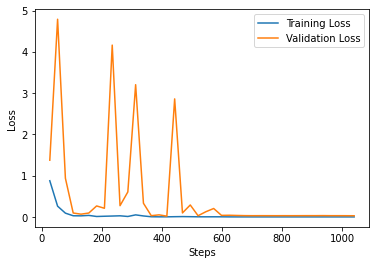

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

2. Image transformation 1

In [ ]:
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform1 = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), 
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(10,expand=True),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     #transforms.Normalize((0.5, ), (0.5, )),
      ])    

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train = FacemaskTypeDataset(train_path, transform=transform1)
dataset_valid = FacemaskTypeDataset(valid_path, transform=transform1)
dataset_test = FacemaskTypeDataset(test_path, transform=transform1)

# Make iterators
bs = 128

train_loader_trans1 = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_trans1 = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_trans1 = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

#dataiter = iter(train_loader)
#image, label = next(dataiter)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2net_trans1_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_trans1, valid_loader_trans1, num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_trans1_best.pt
Epoch [1/40], Step 26, Train Loss: 0.9874, Train Acc: 0.5762, Val Macro Avg: 0.2250, Valid Loss: 2.5389,  Valid Acc: 0.3267
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.23      0.78      0.36       144
           2       0.86      0.09      0.15       141
           3       0.00      0.00      0.00       136
           4       0.50      0.77      0.61       137

    accuracy                           0.33       707
   macro avg       0.32      0.33      0.23       707
weighted avg       0.32      0.33      0.22       707



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to pa2net_trans1_best.pt
Epoch [2/40], Step 52, Train Loss: 0.3678, Train Acc: 0.8667, Val Macro Avg: 0.4867, Valid Loss: 1.7104,  Valid Acc: 0.5615
              precision    recall  f1-score   support

           0       0.47      0.94      0.63       149
           1       0.00      0.00      0.00       144
           2       0.46      0.89      0.61       141
           3       0.88      0.21      0.34       136
           4       1.00      0.75      0.86       137

    accuracy                           0.56       707
   macro avg       0.56      0.56      0.49       707
weighted avg       0.55      0.56      0.49       707




Model saved to pa2net_trans1_best.pt
Epoch [3/40], Step 78, Train Loss: 0.1563, Train Acc: 0.9476, Val Macro Avg: 0.9414, Valid Loss: 0.1801,  Valid Acc: 0.9406
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       149
           1       0.98      0.94      0.96       144
           2       0.90      0.94      0.92       141
           3       1.00      0.88      0.94       136
           4       0.97      1.00      0.99       137

    accuracy                           0.94       707
   macro avg       0.94      0.94      0.94       707
weighted avg       0.94      0.94      0.94       707




Epoch [4/40], Step 104, Train Loss: 0.1003, Train Acc: 0.9682, Val Macro Avg: 0.8406, Valid Loss: 0.4488,  Valid Acc: 0.8444
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       149
           1       0.86      1.00      0.93       144
           2       0.71      0.96      0.82       141
           3       1.00      0.72      0.84       136
           4       0.91      0.96      0.94       137

    accuracy                           0.84       707
   macro avg       0.86      0.85      0.84       707
weighted avg       0.86      0.84      0.84       707




Epoch [5/40], Step 130, Train Loss: 0.0990, Train Acc: 0.9667, Val Macro Avg: 0.9310, Valid Loss: 0.1975,  Valid Acc: 0.9307
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       149
           1       1.00      0.78      0.88       144
           2       0.81      0.91      0.86       141
           3       0.98      0.99      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.93       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [6/40], Step 156, Train Loss: 0.0580, Train Acc: 0.9824, Val Macro Avg: 0.5169, Valid Loss: 1.8909,  Valid Acc: 0.5629
              precision    recall  f1-score   support

           0       1.00      0.32      0.48       149
           1       0.41      0.99      0.58       144
           2       0.10      0.04      0.05       141
           3       1.00      0.49      0.66       136
           4       0.68      0.99      0.81       137

    accuracy                           0.56       707
   macro avg       0.64      0.57      0.52       707
weighted avg       0.64      0.56      0.51       707




Epoch [7/40], Step 182, Train Loss: 0.0566, Train Acc: 0.9827, Val Macro Avg: 0.9242, Valid Loss: 0.2624,  Valid Acc: 0.9236
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       149
           1       1.00      0.74      0.85       144
           2       0.76      0.96      0.85       141
           3       0.96      1.00      0.98       136
           4       1.00      0.96      0.98       137

    accuracy                           0.92       707
   macro avg       0.94      0.92      0.92       707
weighted avg       0.94      0.92      0.92       707




Epoch [8/40], Step 208, Train Loss: 0.0452, Train Acc: 0.9852, Val Macro Avg: 0.9084, Valid Loss: 0.3163,  Valid Acc: 0.9081
              precision    recall  f1-score   support

           0       0.91      0.72      0.81       149
           1       0.94      0.98      0.96       144
           2       1.00      0.85      0.92       141
           3       0.76      1.00      0.86       136
           4       0.99      1.00      1.00       137

    accuracy                           0.91       707
   macro avg       0.92      0.91      0.91       707
weighted avg       0.92      0.91      0.91       707




Model saved to pa2net_trans1_best.pt
Epoch [9/40], Step 234, Train Loss: 0.0309, Train Acc: 0.9909, Val Macro Avg: 0.9550, Valid Loss: 0.1776,  Valid Acc: 0.9547
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       149
           1       1.00      0.86      0.93       144
           2       0.88      0.95      0.91       141
           3       0.99      0.98      0.98       136
           4       0.99      0.99      0.99       137

    accuracy                           0.95       707
   macro avg       0.96      0.95      0.96       707
weighted avg       0.96      0.95      0.95       707




Epoch [10/40], Step 260, Train Loss: 0.0315, Train Acc: 0.9897, Val Macro Avg: 0.5513, Valid Loss: 2.0467,  Valid Acc: 0.6351
              precision    recall  f1-score   support

           0       0.95      0.28      0.43       149
           1       0.49      0.94      0.65       144
           2       0.00      0.00      0.00       141
           3       0.56      1.00      0.71       136
           4       0.94      1.00      0.97       137

    accuracy                           0.64       707
   macro avg       0.59      0.64      0.55       707
weighted avg       0.59      0.64      0.55       707




Epoch [11/40], Step 286, Train Loss: 0.0553, Train Acc: 0.9812, Val Macro Avg: 0.9243, Valid Loss: 0.2449,  Valid Acc: 0.9236
              precision    recall  f1-score   support

           0       0.79      0.96      0.86       149
           1       1.00      0.92      0.96       144
           2       0.97      0.74      0.84       141
           3       0.93      1.00      0.96       136
           4       0.99      1.00      1.00       137

    accuracy                           0.92       707
   macro avg       0.94      0.92      0.92       707
weighted avg       0.93      0.92      0.92       707




Epoch [12/40], Step 312, Train Loss: 0.0328, Train Acc: 0.9894, Val Macro Avg: 0.9479, Valid Loss: 0.1641,  Valid Acc: 0.9477
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       149
           1       1.00      0.81      0.89       144
           2       0.83      0.99      0.90       141
           3       0.99      0.99      0.99       136
           4       0.99      0.98      0.99       137

    accuracy                           0.95       707
   macro avg       0.95      0.95      0.95       707
weighted avg       0.95      0.95      0.95       707




Model saved to pa2net_trans1_best.pt
Epoch [13/40], Step 338, Train Loss: 0.0175, Train Acc: 0.9961, Val Macro Avg: 0.9596, Valid Loss: 0.1465,  Valid Acc: 0.9590
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       149
           1       1.00      0.92      0.96       144
           2       0.94      0.88      0.91       141
           3       1.00      1.00      1.00       136
           4       0.99      0.99      0.99       137

    accuracy                           0.96       707
   macro avg       0.96      0.96      0.96       707
weighted avg       0.96      0.96      0.96       707




Epoch [14/40], Step 364, Train Loss: 0.0275, Train Acc: 0.9930, Val Macro Avg: 0.8831, Valid Loss: 0.3692,  Valid Acc: 0.8840
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       149
           1       0.91      0.99      0.95       144
           2       1.00      0.78      0.88       141
           3       0.72      1.00      0.84       136
           4       0.99      1.00      1.00       137

    accuracy                           0.88       707
   macro avg       0.90      0.89      0.88       707
weighted avg       0.90      0.88      0.88       707




Model saved to pa2net_trans1_best.pt
Epoch [15/40], Step 390, Train Loss: 0.0198, Train Acc: 0.9933, Val Macro Avg: 0.9748, Valid Loss: 0.0754,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       149
           1       1.00      0.97      0.98       144
           2       0.96      0.96      0.96       141
           3       0.96      1.00      0.98       136
           4       0.98      1.00      0.99       137

    accuracy                           0.97       707
   macro avg       0.97      0.98      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [16/40], Step 416, Train Loss: 0.0199, Train Acc: 0.9939, Val Macro Avg: 0.8279, Valid Loss: 0.7193,  Valid Acc: 0.8373
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       149
           1       0.65      0.99      0.79       144
           2       1.00      0.45      0.62       141
           3       0.82      1.00      0.90       136
           4       0.94      1.00      0.97       137

    accuracy                           0.84       707
   macro avg       0.88      0.84      0.83       707
weighted avg       0.88      0.84      0.83       707




Model saved to pa2net_trans1_best.pt
Epoch [17/40], Step 442, Train Loss: 0.0244, Train Acc: 0.9915, Val Macro Avg: 0.9788, Valid Loss: 0.0744,  Valid Acc: 0.9788
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.97      1.00      0.98       144
           2       1.00      0.94      0.97       141
           3       0.96      1.00      0.98       136
           4       1.00      0.97      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [18/40], Step 468, Train Loss: 0.0237, Train Acc: 0.9918, Val Macro Avg: 0.9282, Valid Loss: 0.2972,  Valid Acc: 0.9279
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       149
           1       1.00      0.78      0.88       144
           2       0.98      0.89      0.93       141
           3       0.95      1.00      0.97       136
           4       0.94      0.99      0.96       137

    accuracy                           0.93       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Model saved to pa2net_trans1_best.pt
Epoch [19/40], Step 494, Train Loss: 0.0197, Train Acc: 0.9936, Val Macro Avg: 0.9860, Valid Loss: 0.0665,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.97      1.00      0.99       144
           2       0.99      0.96      0.97       141
           3       0.98      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Model saved to pa2net_trans1_best.pt
Epoch [20/40], Step 520, Train Loss: 0.0111, Train Acc: 0.9976, Val Macro Avg: 0.9860, Valid Loss: 0.0485,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       149
           1       0.99      1.00      1.00       144
           2       0.97      0.99      0.98       141
           3       0.99      0.99      0.99       136
           4       0.99      1.00      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Model saved to pa2net_trans1_best.pt
Epoch [21/40], Step 546, Train Loss: 0.0115, Train Acc: 0.9967, Val Macro Avg: 0.9902, Valid Loss: 0.0539,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       149
           1       0.99      0.99      0.99       144
           2       1.00      0.98      0.99       141
           3       0.97      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [22/40], Step 572, Train Loss: 0.0091, Train Acc: 0.9973, Val Macro Avg: 0.9793, Valid Loss: 0.0908,  Valid Acc: 0.9788
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       149
           1       0.99      0.99      0.99       144
           2       0.91      0.99      0.95       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_trans1_best.pt
Epoch [23/40], Step 598, Train Loss: 0.0090, Train Acc: 0.9970, Val Macro Avg: 0.9916, Valid Loss: 0.0323,  Valid Acc: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       1.00      0.99      1.00       144
           2       0.99      0.98      0.98       141
           3       1.00      0.99      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [24/40], Step 624, Train Loss: 0.0061, Train Acc: 0.9979, Val Macro Avg: 0.9738, Valid Loss: 0.0991,  Valid Acc: 0.9731
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       149
           1       1.00      0.98      0.99       144
           2       0.99      0.91      0.95       141
           3       0.99      1.00      1.00       136
           4       1.00      0.98      0.99       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.97       707
weighted avg       0.98      0.97      0.97       707




Epoch [25/40], Step 650, Train Loss: 0.0122, Train Acc: 0.9973, Val Macro Avg: 0.9664, Valid Loss: 0.1265,  Valid Acc: 0.9661
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       149
           1       0.99      1.00      0.99       144
           2       0.88      0.98      0.93       141
           3       0.97      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [26/40], Step 676, Train Loss: 0.0246, Train Acc: 0.9924, Val Macro Avg: 0.9332, Valid Loss: 0.3266,  Valid Acc: 0.9335
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       149
           1       1.00      0.74      0.85       144
           2       0.79      0.96      0.87       141
           3       0.97      0.99      0.98       136
           4       1.00      0.98      0.99       137

    accuracy                           0.93       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [27/40], Step 702, Train Loss: 0.0235, Train Acc: 0.9933, Val Macro Avg: 0.8117, Valid Loss: 0.9388,  Valid Acc: 0.8317
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       149
           1       1.00      0.27      0.43       144
           2       0.56      0.92      0.70       141
           3       1.00      0.99      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.83       707
   macro avg       0.89      0.83      0.81       707
weighted avg       0.89      0.83      0.81       707




Model saved to pa2net_trans1_best.pt
Epoch [28/40], Step 728, Train Loss: 0.0149, Train Acc: 0.9955, Val Macro Avg: 0.9931, Valid Loss: 0.0255,  Valid Acc: 0.9929
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.99      0.99      0.99       144
           2       0.99      0.98      0.99       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [29/40], Step 754, Train Loss: 0.0046, Train Acc: 0.9988, Val Macro Avg: 0.9691, Valid Loss: 0.1009,  Valid Acc: 0.9689
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       149
           1       0.99      0.99      0.99       144
           2       0.99      0.85      0.92       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [30/40], Step 780, Train Loss: 0.0177, Train Acc: 0.9942, Val Macro Avg: 0.7748, Valid Loss: 1.6522,  Valid Acc: 0.8119
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       149
           1       0.52      1.00      0.69       144
           2       1.00      0.13      0.23       141
           3       1.00      1.00      1.00       136
           4       1.00      0.99      0.99       137

    accuracy                           0.81       707
   macro avg       0.90      0.81      0.77       707
weighted avg       0.90      0.81      0.77       707




Epoch [31/40], Step 806, Train Loss: 0.0254, Train Acc: 0.9924, Val Macro Avg: 0.9805, Valid Loss: 0.0597,  Valid Acc: 0.9802
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.99      0.94      0.96       144
           2       0.93      0.98      0.95       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [32/40], Step 832, Train Loss: 0.0084, Train Acc: 0.9985, Val Macro Avg: 0.9861, Valid Loss: 0.0795,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       149
           1       0.95      1.00      0.97       144
           2       0.99      0.97      0.98       141
           3       1.00      0.99      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [33/40], Step 858, Train Loss: 0.0038, Train Acc: 0.9988, Val Macro Avg: 0.9845, Valid Loss: 0.0450,  Valid Acc: 0.9844
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       149
           1       0.99      0.94      0.96       144
           2       0.95      0.99      0.97       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [34/40], Step 884, Train Loss: 0.0044, Train Acc: 0.9994, Val Macro Avg: 0.9818, Valid Loss: 0.0735,  Valid Acc: 0.9816
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       149
           1       0.94      1.00      0.97       144
           2       0.99      0.94      0.96       141
           3       0.99      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_trans1_best.pt
Epoch [35/40], Step 910, Train Loss: 0.0021, Train Acc: 0.9991, Val Macro Avg: 0.9944, Valid Loss: 0.0307,  Valid Acc: 0.9943
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       1.00      1.00      1.00       144
           2       1.00      0.98      0.99       141
           3       0.99      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [36/40], Step 936, Train Loss: 0.0077, Train Acc: 0.9967, Val Macro Avg: 0.9903, Valid Loss: 0.0343,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       149
           1       0.99      0.99      0.99       144
           2       0.99      0.96      0.98       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [37/40], Step 962, Train Loss: 0.0072, Train Acc: 0.9976, Val Macro Avg: 0.9889, Valid Loss: 0.0660,  Valid Acc: 0.9887
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       149
           1       0.99      0.99      0.99       144
           2       0.97      0.98      0.97       141
           3       1.00      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [38/40], Step 988, Train Loss: 0.0026, Train Acc: 0.9994, Val Macro Avg: 0.9917, Valid Loss: 0.0399,  Valid Acc: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [39/40], Step 1014, Train Loss: 0.0042, Train Acc: 0.9988, Val Macro Avg: 0.9902, Valid Loss: 0.0459,  Valid Acc: 0.9901
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       149
           1       0.99      0.99      0.99       144
           2       0.99      0.97      0.98       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [40/40], Step 1040, Train Loss: 0.0237, Train Acc: 0.9924, Val Macro Avg: 0.9761, Valid Loss: 0.1110,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.99      0.91      0.95       144
           2       0.91      0.99      0.95       141
           3       1.00      0.99      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707

Finished Training
Best validation macro average: 0.9943829193877821
Best validation loss: 0.030734517712999954


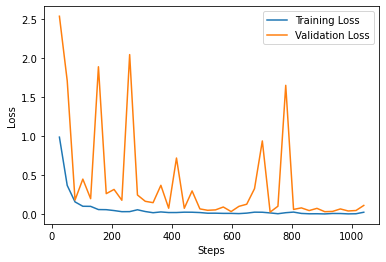

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

3. Image transformation 2

In [ ]:
train_path = '/content/train.csv'
valid_path = '/content/valid.csv'
test_path = '/content/test.csv'

transform1 = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), 
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(10,expand=True),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, )),
      ])    

transform2 = transforms.Compose(
    [transforms.Resize((36,36)),
      transforms.Grayscale(num_output_channels=1),
      transforms.RandomCrop(size=32),
      transforms.RandomRotation(degrees=(5, 15)),
      transforms.RandomHorizontalFlip(p=0.8),         
      transforms.ToTensor(),                 
      transforms.Normalize((0.5, ), (0.5, )),
      ])    

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_train = FacemaskTypeDataset(train_path, transform=transform2)
dataset_valid = FacemaskTypeDataset(valid_path, transform=transform2)
dataset_test = FacemaskTypeDataset(test_path, transform=transform2)

# Make iterators
bs = 128

train_loader_trans2 = DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader_trans2  = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_loader_trans2  = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

#dataiter = iter(train_loader)
#image, label = next(dataiter)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = PA2Net()
num_epochs = 40
criterion = nn.CrossEntropyLoss()
save_path = f'pa2net_trans2_best.pt'
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

train_loss_ls, val_loss_ls, steps_ls, best_model = TRAIN(model, train_loader_trans2 , valid_loader_trans2 , num_epochs, criterion, optimizer, device, save_path)


cuda



Model saved to pa2net_trans2_best.pt
Epoch [1/40], Step 26, Train Loss: 0.9031, Train Acc: 0.6144, Val Macro Avg: 0.5915, Valid Loss: 0.8310,  Valid Acc: 0.6591
              precision    recall  f1-score   support

           0       0.94      0.44      0.60       149
           1       0.44      0.95      0.60       144
           2       0.00      0.00      0.00       141
           3       0.75      0.95      0.83       136
           4       0.87      0.99      0.92       137

    accuracy                           0.66       707
   macro avg       0.60      0.66      0.59       707
weighted avg       0.60      0.66      0.59       707



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model saved to pa2net_trans2_best.pt
Epoch [2/40], Step 52, Train Loss: 0.2968, Train Acc: 0.8915, Val Macro Avg: 0.8196, Valid Loss: 0.4555,  Valid Acc: 0.8260
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       149
           1       1.00      0.45      0.62       144
           2       0.61      0.93      0.74       141
           3       0.88      0.99      0.93       136
           4       0.94      1.00      0.97       137

    accuracy                           0.83       707
   macro avg       0.87      0.83      0.82       707
weighted avg       0.87      0.83      0.82       707




Epoch [3/40], Step 78, Train Loss: 0.1618, Train Acc: 0.9509, Val Macro Avg: 0.7746, Valid Loss: 0.8889,  Valid Acc: 0.7680
              precision    recall  f1-score   support

           0       0.97      0.47      0.63       149
           1       0.52      0.99      0.68       144
           2       0.76      0.64      0.69       141
           3       0.98      0.87      0.92       136
           4       1.00      0.90      0.95       137

    accuracy                           0.77       707
   macro avg       0.85      0.77      0.77       707
weighted avg       0.84      0.77      0.77       707




Model saved to pa2net_trans2_best.pt
Epoch [4/40], Step 104, Train Loss: 0.1224, Train Acc: 0.9576, Val Macro Avg: 0.9462, Valid Loss: 0.1858,  Valid Acc: 0.9463
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       149
           1       0.91      0.99      0.95       144
           2       1.00      0.86      0.92       141
           3       0.90      1.00      0.95       136
           4       0.99      1.00      0.99       137

    accuracy                           0.95       707
   macro avg       0.95      0.95      0.95       707
weighted avg       0.95      0.95      0.95       707




Model saved to pa2net_trans2_best.pt
Epoch [5/40], Step 130, Train Loss: 0.0727, Train Acc: 0.9788, Val Macro Avg: 0.9691, Valid Loss: 0.1051,  Valid Acc: 0.9689
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       149
           1       0.99      0.91      0.95       144
           2       0.91      0.99      0.95       141
           3       1.00      0.98      0.99       136
           4       0.97      0.99      0.98       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Model saved to pa2net_trans2_best.pt
Epoch [6/40], Step 156, Train Loss: 0.0476, Train Acc: 0.9858, Val Macro Avg: 0.9746, Valid Loss: 0.0811,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       149
           1       0.97      0.99      0.98       144
           2       0.99      0.94      0.96       141
           3       1.00      0.95      0.97       136
           4       0.97      1.00      0.99       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.97       707
weighted avg       0.98      0.97      0.97       707




Epoch [7/40], Step 182, Train Loss: 0.0615, Train Acc: 0.9794, Val Macro Avg: 0.9651, Valid Loss: 0.1111,  Valid Acc: 0.9646
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       149
           1       1.00      0.88      0.94       144
           2       0.88      0.97      0.93       141
           3       1.00      0.99      1.00       136
           4       0.99      0.99      0.99       137

    accuracy                           0.96       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.96      0.96       707




Epoch [8/40], Step 208, Train Loss: 0.0462, Train Acc: 0.9879, Val Macro Avg: 0.9746, Valid Loss: 0.0868,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       149
           1       0.92      0.99      0.95       144
           2       1.00      0.91      0.96       141
           3       0.99      0.99      0.99       136
           4       0.96      1.00      0.98       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.97       707
weighted avg       0.98      0.97      0.97       707




Epoch [9/40], Step 234, Train Loss: 0.0386, Train Acc: 0.9867, Val Macro Avg: 0.9664, Valid Loss: 0.1111,  Valid Acc: 0.9661
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       149
           1       0.97      0.99      0.98       144
           2       0.99      0.96      0.98       141
           3       0.89      1.00      0.94       136
           4       1.00      0.99      0.99       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [10/40], Step 260, Train Loss: 0.0390, Train Acc: 0.9870, Val Macro Avg: 0.8690, Valid Loss: 0.4553,  Valid Acc: 0.8727
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       149
           1       1.00      0.95      0.98       144
           2       0.87      0.99      0.92       141
           3       1.00      0.54      0.70       136
           4       1.00      0.93      0.96       137

    accuracy                           0.87       707
   macro avg       0.91      0.87      0.87       707
weighted avg       0.90      0.87      0.87       707




Epoch [11/40], Step 286, Train Loss: 0.0347, Train Acc: 0.9882, Val Macro Avg: 0.9624, Valid Loss: 0.1244,  Valid Acc: 0.9618
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       149
           1       0.99      0.95      0.97       144
           2       0.95      0.88      0.92       141
           3       1.00      0.99      0.99       136
           4       0.99      0.99      0.99       137

    accuracy                           0.96       707
   macro avg       0.97      0.96      0.96       707
weighted avg       0.96      0.96      0.96       707




Epoch [12/40], Step 312, Train Loss: 0.0403, Train Acc: 0.9864, Val Macro Avg: 0.8746, Valid Loss: 0.4386,  Valid Acc: 0.8670
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       149
           1       0.99      0.86      0.92       144
           2       0.99      0.87      0.92       141
           3       1.00      0.73      0.84       136
           4       0.60      1.00      0.75       137

    accuracy                           0.87       707
   macro avg       0.92      0.87      0.87       707
weighted avg       0.92      0.87      0.88       707




Epoch [13/40], Step 338, Train Loss: 0.0242, Train Acc: 0.9921, Val Macro Avg: 0.9692, Valid Loss: 0.0959,  Valid Acc: 0.9689
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       149
           1       0.99      0.93      0.96       144
           2       0.96      0.97      0.96       141
           3       1.00      0.96      0.98       136
           4       0.98      0.99      0.98       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Model saved to pa2net_trans2_best.pt
Epoch [14/40], Step 364, Train Loss: 0.0311, Train Acc: 0.9906, Val Macro Avg: 0.9791, Valid Loss: 0.0596,  Valid Acc: 0.9788
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       149
           1       0.99      0.99      0.99       144
           2       0.93      0.99      0.96       141
           3       0.98      1.00      0.99       136
           4       1.00      0.99      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_trans2_best.pt
Epoch [15/40], Step 390, Train Loss: 0.0248, Train Acc: 0.9918, Val Macro Avg: 0.9833, Valid Loss: 0.0440,  Valid Acc: 0.9830
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       149
           1       0.99      0.99      0.99       144
           2       0.99      0.96      0.97       141
           3       0.99      0.99      0.99       136
           4       1.00      0.99      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [16/40], Step 416, Train Loss: 0.0212, Train Acc: 0.9936, Val Macro Avg: 0.9309, Valid Loss: 0.2208,  Valid Acc: 0.9307
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       149
           1       1.00      0.92      0.96       144
           2       0.95      0.81      0.87       141
           3       0.94      1.00      0.97       136
           4       0.94      1.00      0.97       137

    accuracy                           0.93       707
   macro avg       0.93      0.93      0.93       707
weighted avg       0.93      0.93      0.93       707




Model saved to pa2net_trans2_best.pt
Epoch [17/40], Step 442, Train Loss: 0.0127, Train Acc: 0.9964, Val Macro Avg: 0.9846, Valid Loss: 0.0612,  Valid Acc: 0.9844
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       149
           1       0.99      0.99      0.99       144
           2       0.96      0.99      0.98       141
           3       0.99      1.00      0.99       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.99      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [18/40], Step 468, Train Loss: 0.0206, Train Acc: 0.9939, Val Macro Avg: 0.9380, Valid Loss: 0.2621,  Valid Acc: 0.9378
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       149
           1       0.99      0.77      0.87       144
           2       0.80      0.94      0.87       141
           3       0.99      1.00      1.00       136
           4       0.99      0.99      0.99       137

    accuracy                           0.94       707
   macro avg       0.95      0.94      0.94       707
weighted avg       0.94      0.94      0.94       707




Epoch [19/40], Step 494, Train Loss: 0.0163, Train Acc: 0.9961, Val Macro Avg: 0.7737, Valid Loss: 0.9795,  Valid Acc: 0.8076
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       149
           1       0.53      0.99      0.69       144
           2       1.00      0.16      0.27       141
           3       0.93      1.00      0.96       136
           4       1.00      1.00      1.00       137

    accuracy                           0.81       707
   macro avg       0.89      0.81      0.77       707
weighted avg       0.89      0.81      0.77       707




Epoch [20/40], Step 520, Train Loss: 0.0510, Train Acc: 0.9842, Val Macro Avg: 0.7925, Valid Loss: 0.8325,  Valid Acc: 0.8006
              precision    recall  f1-score   support

           0       0.71      0.87      0.79       149
           1       0.66      0.99      0.79       144
           2       0.90      0.98      0.94       141
           3       1.00      0.52      0.69       136
           4       1.00      0.61      0.76       137

    accuracy                           0.80       707
   macro avg       0.86      0.80      0.79       707
weighted avg       0.85      0.80      0.79       707




Epoch [21/40], Step 546, Train Loss: 0.0196, Train Acc: 0.9942, Val Macro Avg: 0.9747, Valid Loss: 0.0988,  Valid Acc: 0.9745
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       149
           1       0.99      0.99      0.99       144
           2       0.99      0.96      0.98       141
           3       0.92      1.00      0.96       136
           4       0.99      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.98      0.98      0.97       707
weighted avg       0.98      0.97      0.97       707




Epoch [22/40], Step 572, Train Loss: 0.0343, Train Acc: 0.9885, Val Macro Avg: 0.9336, Valid Loss: 0.2271,  Valid Acc: 0.9335
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       149
           1       1.00      0.92      0.96       144
           2       0.83      0.99      0.90       141
           3       0.89      1.00      0.94       136
           4       0.99      1.00      0.99       137

    accuracy                           0.93       707
   macro avg       0.94      0.94      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [23/40], Step 598, Train Loss: 0.0248, Train Acc: 0.9918, Val Macro Avg: 0.9702, Valid Loss: 0.1393,  Valid Acc: 0.9703
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       149
           1       0.99      0.99      0.99       144
           2       0.99      0.97      0.98       141
           3       0.94      0.98      0.96       136
           4       0.94      1.00      0.97       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [24/40], Step 624, Train Loss: 0.0174, Train Acc: 0.9945, Val Macro Avg: 0.9561, Valid Loss: 0.1856,  Valid Acc: 0.9547
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       149
           1       0.99      0.96      0.98       144
           2       0.82      0.99      0.90       141
           3       1.00      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.95       707
   macro avg       0.96      0.96      0.96       707
weighted avg       0.96      0.95      0.96       707




Epoch [25/40], Step 650, Train Loss: 0.0245, Train Acc: 0.9909, Val Macro Avg: 0.9336, Valid Loss: 0.2430,  Valid Acc: 0.9335
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       149
           1       1.00      0.97      0.99       144
           2       0.98      0.72      0.83       141
           3       0.96      1.00      0.98       136
           4       1.00      1.00      1.00       137

    accuracy                           0.93       707
   macro avg       0.95      0.93      0.93       707
weighted avg       0.94      0.93      0.93       707




Epoch [26/40], Step 676, Train Loss: 0.0135, Train Acc: 0.9958, Val Macro Avg: 0.9738, Valid Loss: 0.0765,  Valid Acc: 0.9731
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       149
           1       1.00      0.96      0.98       144
           2       0.99      0.91      0.95       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.98      0.97      0.97       707
weighted avg       0.98      0.97      0.97       707




Epoch [27/40], Step 702, Train Loss: 0.0116, Train Acc: 0.9967, Val Macro Avg: 0.9762, Valid Loss: 0.0742,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       149
           1       1.00      0.92      0.96       144
           2       0.92      0.99      0.95       141
           3       1.00      1.00      1.00       136
           4       0.97      1.00      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Model saved to pa2net_trans2_best.pt
Epoch [28/40], Step 728, Train Loss: 0.0144, Train Acc: 0.9945, Val Macro Avg: 0.9917, Valid Loss: 0.0352,  Valid Acc: 0.9915
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       149
           1       0.99      0.99      0.99       144
           2       1.00      0.98      0.99       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [29/40], Step 754, Train Loss: 0.0080, Train Acc: 0.9970, Val Macro Avg: 0.9705, Valid Loss: 0.1003,  Valid Acc: 0.9703
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       149
           1       0.99      0.90      0.94       144
           2       0.91      0.97      0.94       141
           3       0.99      1.00      0.99       136
           4       0.99      1.00      1.00       137

    accuracy                           0.97       707
   macro avg       0.97      0.97      0.97       707
weighted avg       0.97      0.97      0.97       707




Epoch [30/40], Step 780, Train Loss: 0.0143, Train Acc: 0.9949, Val Macro Avg: 0.9763, Valid Loss: 0.0854,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       149
           1       0.99      0.98      0.98       144
           2       0.92      0.99      0.96       141
           3       0.99      1.00      0.99       136
           4       0.99      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [31/40], Step 806, Train Loss: 0.0098, Train Acc: 0.9970, Val Macro Avg: 0.9762, Valid Loss: 0.0847,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       149
           1       0.99      0.94      0.97       144
           2       0.96      0.94      0.95       141
           3       1.00      1.00      1.00       136
           4       0.98      1.00      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [32/40], Step 832, Train Loss: 0.0125, Train Acc: 0.9958, Val Macro Avg: 0.9764, Valid Loss: 0.0909,  Valid Acc: 0.9760
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       149
           1       0.93      1.00      0.96       144
           2       0.99      0.94      0.96       141
           3       1.00      0.99      1.00       136
           4       1.00      0.98      0.99       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [33/40], Step 858, Train Loss: 0.0096, Train Acc: 0.9973, Val Macro Avg: 0.9874, Valid Loss: 0.0412,  Valid Acc: 0.9873
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       149
           1       0.99      0.97      0.98       144
           2       0.97      0.99      0.98       141
           3       0.99      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [34/40], Step 884, Train Loss: 0.0096, Train Acc: 0.9970, Val Macro Avg: 0.9860, Valid Loss: 0.0777,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       149
           1       0.99      0.97      0.98       144
           2       0.97      0.97      0.97       141
           3       0.99      1.00      1.00       136
           4       1.00      0.99      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [35/40], Step 910, Train Loss: 0.0051, Train Acc: 0.9985, Val Macro Avg: 0.9916, Valid Loss: 0.0437,  Valid Acc: 0.9915
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.99      0.99      0.99       144
           2       0.99      0.99      0.99       141
           3       0.99      1.00      1.00       136
           4       0.99      1.00      0.99       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [36/40], Step 936, Train Loss: 0.0058, Train Acc: 0.9979, Val Macro Avg: 0.9832, Valid Loss: 0.0705,  Valid Acc: 0.9830
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       149
           1       1.00      0.99      1.00       144
           2       1.00      0.92      0.96       141
           3       0.99      1.00      0.99       136
           4       1.00      1.00      1.00       137

    accuracy                           0.98       707
   macro avg       0.98      0.98      0.98       707
weighted avg       0.98      0.98      0.98       707




Epoch [37/40], Step 962, Train Loss: 0.0052, Train Acc: 0.9982, Val Macro Avg: 0.9888, Valid Loss: 0.0455,  Valid Acc: 0.9887
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       149
           1       1.00      0.99      1.00       144
           2       0.98      0.97      0.98       141
           3       0.99      1.00      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [38/40], Step 988, Train Loss: 0.0141, Train Acc: 0.9942, Val Macro Avg: 0.9102, Valid Loss: 0.4816,  Valid Acc: 0.9109
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       149
           1       0.90      0.99      0.94       144
           2       0.93      0.96      0.94       141
           3       0.79      1.00      0.88       136
           4       1.00      0.84      0.91       137

    accuracy                           0.91       707
   macro avg       0.92      0.91      0.91       707
weighted avg       0.92      0.91      0.91       707




Epoch [39/40], Step 1014, Train Loss: 0.0133, Train Acc: 0.9961, Val Macro Avg: 0.9888, Valid Loss: 0.0461,  Valid Acc: 0.9887
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.99      0.97      0.98       144
           2       0.98      0.99      0.98       141
           3       1.00      0.99      1.00       136
           4       0.99      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707




Epoch [40/40], Step 1040, Train Loss: 0.0201, Train Acc: 0.9939, Val Macro Avg: 0.9861, Valid Loss: 0.0709,  Valid Acc: 0.9859
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       149
           1       0.98      0.99      0.98       144
           2       0.99      0.96      0.97       141
           3       0.99      1.00      1.00       136
           4       1.00      1.00      1.00       137

    accuracy                           0.99       707
   macro avg       0.99      0.99      0.99       707
weighted avg       0.99      0.99      0.99       707

Finished Training
Best validation macro average: 0.9916724171885463
Best validation loss: 0.03517245130257207


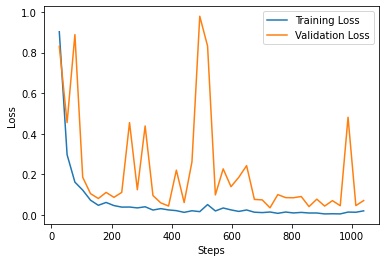

In [ ]:
plt.plot(steps_ls, train_loss_ls, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(steps_ls, val_loss_ls, label='Validation Loss')
plt.legend()
plt.show()

# Testing Set

In [ ]:
import os

DIR2 = '/gdrive/MyDrive/50imgstest'

col = ['filename', 'mask_type', 'class', 'correct_class']
test_df = pd.DataFrame(columns=col)
print(test_df)

for file in os.listdir(DIR2):
  test_df = test_df.append({'filename':file, 'mask_type':'unknown', 'class':-1, 'correct_class':file[-5]}, ignore_index=True)

test_df.head()

Empty DataFrame
Columns: [filename, mask_type, class, correct_class]
Index: []


,filename,mask_type,class,correct_class
0,maksssksksss732_2_class_4.png,unknown,-1,4
1,maksssksksss824_2_class_4.png,unknown,-1,4
2,maksssksksss731_1_class_1.png,unknown,-1,1
3,maksssksksss700_1_class_1.png,unknown,-1,1
4,maksssksksss736_0_class_4.png,unknown,-1,4


In [ ]:
test_df.to_csv('/content/testkaggle.csv')

In [ ]:
# Make the dataset class
class FacemaskTypeDataset2(Dataset):
  def __init__(self, csv_file, transform=None, rgb=False):
    self.index_df = pd.read_csv(csv_file)
    self.transform = transform
    self.DIR = '/gdrive/MyDrive/50imgstest'
    if rgb:
      self.is_rgb = True
    else:
      self.is_rgb = False

  def __getitem__(self, idx):
    img = os.path.join(self.DIR,self.index_df.loc[idx, 'filename'])
    image = Image.open(img)
    if self.is_rgb:
      image = image.convert('RGB')
    image_tr = self.transform(image)
    label = self.index_df.loc[idx, 'correct_class']
    return image_tr, label

  def __len__(self):
    return len(self.index_df)

In [ ]:
test_path2 = '/content/testkaggle.csv'

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      #transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_test2 = FacemaskTypeDataset2(test_path2, transform=transform0, rgb=True)

# Make iterators
bs = 128
test_loader_rgb2 = DataLoader(dataset_test2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

#dataiter = iter(train_loader)
#image, label = next(dataiter)

In [ ]:
# Best model was the RGBmodel
#net = torch.load('/content/RGBNet_best.pt')
net = torch.load('/content/pa2net_rgb_best.pt')
#net = torch.load('/content/transformations_pa2net_best.pt')
#net = torch.load('/content/pa2net_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader_rgb2:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_rgb)
  valid_acc = val_running_corrects / float(len(valid_loader_rgb.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.50      0.08      0.14        24
           2       0.12      1.00      0.22         4
           3       0.00      0.00      0.00         0
           4       0.81      0.94      0.87        18

    accuracy                           0.37        62
   macro avg       0.29      0.41      0.25        62
weighted avg       0.44      0.37      0.32        62



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Transformation 1 Classification report
test_path2 = '/content/testkaggle.csv'

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_test2 = FacemaskTypeDataset2(test_path2, transform=transform0)

# Make iterators
bs = 128
test_loader_trans1 = DataLoader(dataset_test2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


# Best model was the RGBmodel
#net = torch.load('/content/RGBNet_best.pt')
net = torch.load('/content/pa2net_trans1_best.pt')
#net = torch.load('/content/transformations_pa2net_best.pt')
#net = torch.load('/content/pa2net_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader_trans1:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_trans1)
  valid_acc = val_running_corrects / float(len(valid_loader_trans1.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.50      0.12      0.20        16
           1       0.88      0.29      0.44        24
           2       0.10      0.50      0.17         4
           3       0.00      0.00      0.00         0
           4       0.63      0.94      0.76        18

    accuracy                           0.45        62
   macro avg       0.42      0.37      0.31        62
weighted avg       0.66      0.45      0.45        62



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Transformation 2 Classification report
test_path2 = '/content/testkaggle.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(), 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_test2 = FacemaskTypeDataset2(test_path2, transform=transform0)

# Make iterators
bs = 128
test_loader_trans2 = DataLoader(dataset_test2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


# Best model was the RGBmodel
#net = torch.load('/content/RGBNet_best.pt')
net = torch.load('/content/pa2net_trans2_best.pt')
#net = torch.load('/content/transformations_pa2net_best.pt')
#net = torch.load('/content/pa2net_best.pt')
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader_trans2:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_trans2)
  valid_acc = val_running_corrects / float(len(valid_loader_trans2.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.11      0.06      0.08        16
           1       0.80      0.17      0.28        24
           2       0.12      1.00      0.21         4
           3       0.00      0.00      0.00         0
           4       0.90      0.50      0.64        18

    accuracy                           0.29        62
   macro avg       0.39      0.35      0.24        62
weighted avg       0.61      0.29      0.33        62



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Baseline model classification report

test_path2 = '/content/testkaggle.csv'

transform0 = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Grayscale(num_output_channels=1),
      transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
      #transforms.Normalize((0.5, ), (0.5, )),
      #transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))   # channel=（channel-mean）/std  -> [-1, 1]
      ])

dataset_test2 = FacemaskTypeDataset2(test_path2, transform=transform0)

# Make iterators
bs = 128
test_loader_baseline = DataLoader(dataset_test2, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

net = torch.load('/content/pa2net_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader_baseline:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_rgb)
  valid_acc = val_running_corrects / float(len(valid_loader_rgb.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.40      0.12      0.19        16
           1       0.85      0.46      0.59        24
           2       0.11      0.50      0.17         4
           3       0.00      0.00      0.00         0
           4       0.77      0.94      0.85        18

    accuracy                           0.52        62
   macro avg       0.42      0.41      0.36        62
weighted avg       0.66      0.52      0.54        62



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Transformation1 model

net = torch.load('/content/pa2net_trans1_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_rgb)
  valid_acc = val_running_corrects / float(len(valid_loader_rgb.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       139
           1       1.00      0.99      1.00       157
           2       1.00      0.97      0.99       137
           3       0.98      1.00      0.99       149
           4       1.00      1.00      1.00       126

    accuracy                           0.99       708
   macro avg       0.99      0.99      0.99       708
weighted avg       0.99      0.99      0.99       708



In [ ]:
# Transformation2 model

net = torch.load('/content/pa2net_trans2_best.pt')

with torch.no_grad():
  net.eval()
  val_running_loss = 0.0
  val_running_corrects = 0
  pred_ls = []
  target_ls = []
  tmp_ls = []
  # Predict on validation dataset
  for input_x, target in test_loader:

      input_x = input_x.to(device)
      target = target.to(device)

      outputs = net(input_x)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      preds = torch.argmax(outputs)
      val_running_corrects += torch.sum(preds == target.data)
      pred_ls.append(preds.item())
      target_ls.append(target.item())

  cr = classification_report(target_ls, pred_ls)
  cr_dict = classification_report(target_ls, pred_ls, output_dict=True)
  macro_avg = cr_dict['macro avg']['f1-score']
  valid_loss = val_running_loss / len(valid_loader_rgb)
  valid_acc = val_running_corrects / float(len(valid_loader_rgb.dataset))
  print(cr)

              precision    recall  f1-score   support

           0       0.44      0.78      0.56       139
           1       0.62      0.61      0.61       157
           2       0.61      0.91      0.73       137
           3       0.48      0.23      0.31       149
           4       0.94      0.23      0.37       126

    accuracy                           0.55       708
   macro avg       0.62      0.55      0.52       708
weighted avg       0.61      0.55      0.52       708

